# Why study GANs ?
<a href=http://www.iangoodfellow.com/slides/2016-12-04-NIPS.pdf>Ian Goodfellow - NIPS 2016</a>

# Deep Convolutional GAN - DCGAN
## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from datetime import datetime, date, time

Using TensorFlow backend.


## Input dimensions

In [2]:
img_rows = 28
img_cols = img_rows
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100

## Generator

In [3]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    
    model.add(Activation('tanh'))
    
    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Build and compile the DGAN

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_generator(z_dim)

discriminator.trainable = False

# Build and compile the gan
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train the DGAN

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    print('Load MNIST...')
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale pixels from [0-255] to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real and fake images
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    start_training = datetime.now()
    print('Start training...')
    for iteration in range(iterations):
        # Get a random sample from training dataset
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # Create the random input to train the discriminato
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # and passes to the generator
        gen_imgs = generator.predict(z)
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Create new random input for the generator
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # Train the generator
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print(f'{iteration+1} [D loss: {d_loss}, acc: {100.0 * accuracy}%] [G loss]: {g_loss}')
            print(f'Elapsed time = {datetime.now()-start_training}')
            sample_images(generator)
    
    print(f'Total training time: {datetime.now() - start_training}')

## Display images

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Run the model

In [9]:
iterations = 80000
batch_size = 128
sample_interval = 1000

Load MNIST...
Start training...


/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.32129979133605957, acc: 83.203125%] [G loss]: 5.112001419067383
Elapsed time = 0:17:25.831364
2000 [D loss: 0.17710672318935394, acc: 94.140625%] [G loss]: 3.146683692932129
Elapsed time = 0:35:14.922514
3000 [D loss: 0.047540415078401566, acc: 99.609375%] [G loss]: 3.6992428302764893
Elapsed time = 0:54:00.845924
4000 [D loss: 0.07224200665950775, acc: 99.609375%] [G loss]: 3.283672332763672
Elapsed time = 1:15:01.229564
5000 [D loss: 0.7381899356842041, acc: 62.5%] [G loss]: 3.194777727127075
Elapsed time = 1:36:18.894228
6000 [D loss: 0.02385803684592247, acc: 100.0%] [G loss]: 3.6940646171569824
Elapsed time = 1:50:51.234248
7000 [D loss: 0.07464734464883804, acc: 99.609375%] [G loss]: 3.590930461883545
Elapsed time = 2:02:52.411936
8000 [D loss: 0.039801210165023804, acc: 99.609375%] [G loss]: 5.186201095581055
Elapsed time = 2:15:55.224973
9000 [D loss: 0.02082594856619835, acc: 100.0%] [G loss]: 5.15311336517334
Elapsed time = 2:28:21.152576
10000 [D loss: 0.0142

/Users/stelling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22000 [D loss: 0.04669668525457382, acc: 98.828125%] [G loss]: 4.1016645431518555
Elapsed time = 4:48:08.701854
23000 [D loss: 0.22066816687583923, acc: 87.5%] [G loss]: 4.808492660522461
Elapsed time = 4:58:37.608778
24000 [D loss: 0.02924325130879879, acc: 100.0%] [G loss]: 5.792760848999023
Elapsed time = 5:09:04.160386
25000 [D loss: 0.08369608223438263, acc: 97.65625%] [G loss]: 2.3293683528900146
Elapsed time = 5:19:32.907688
26000 [D loss: 0.022410621866583824, acc: 100.0%] [G loss]: 4.757532119750977
Elapsed time = 5:29:59.496177
27000 [D loss: 0.037339404225349426, acc: 100.0%] [G loss]: 4.55510139465332
Elapsed time = 5:40:29.045599
28000 [D loss: 0.03147388622164726, acc: 99.609375%] [G loss]: 6.179544448852539
Elapsed time = 5:50:59.018433
29000 [D loss: 0.01878647319972515, acc: 100.0%] [G loss]: 4.810729026794434
Elapsed time = 6:01:28.568039
30000 [D loss: 0.089040607213974, acc: 97.65625%] [G loss]: 2.6733992099761963
Elapsed time = 6:12:10.098859
31000 [D loss: 0.10066

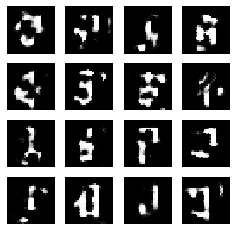

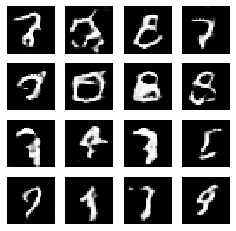

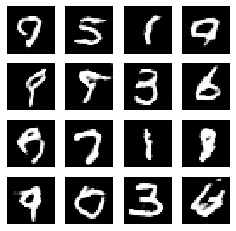

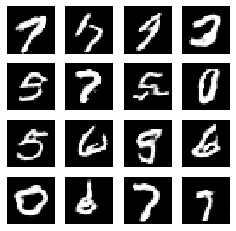

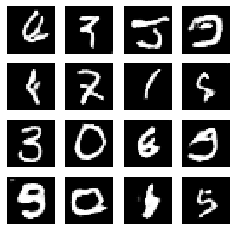

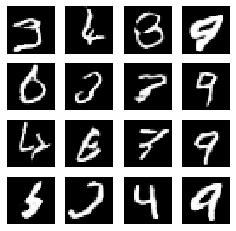

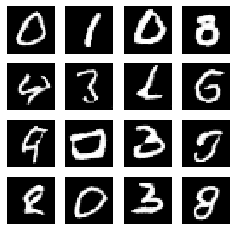

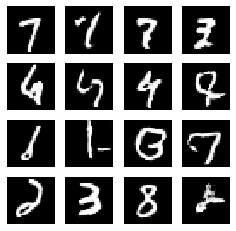

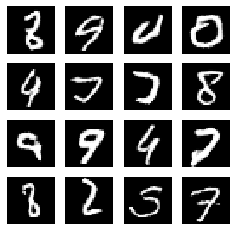

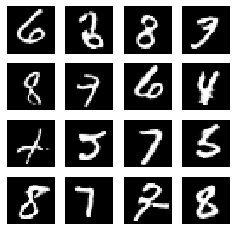

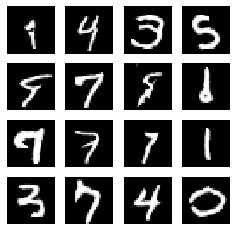

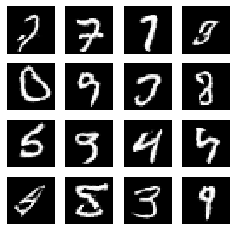

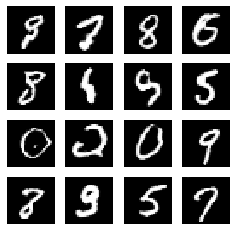

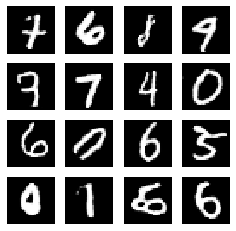

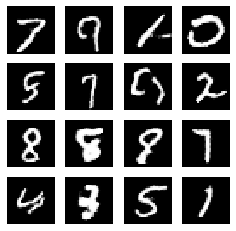

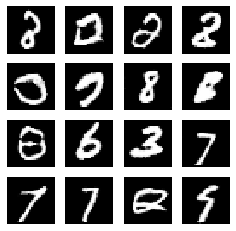

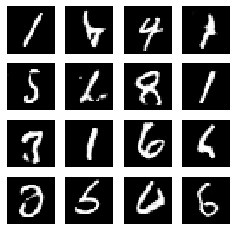

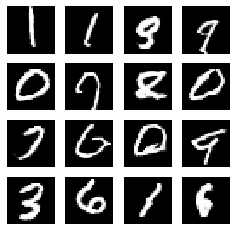

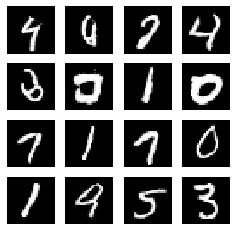

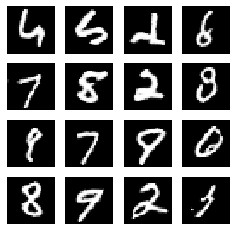

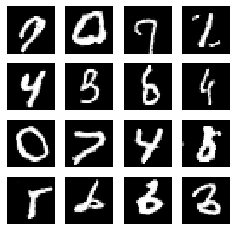

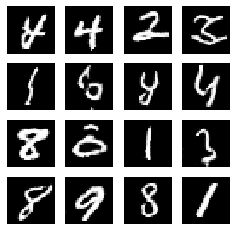

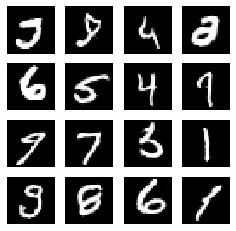

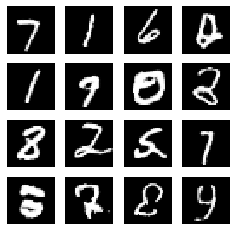

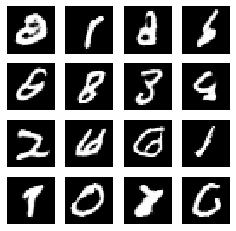

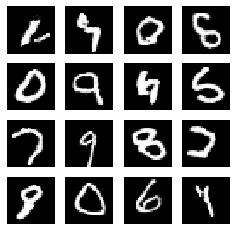

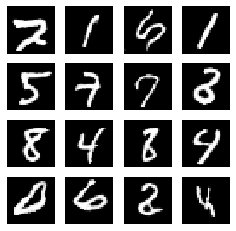

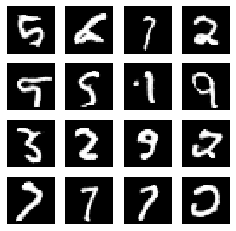

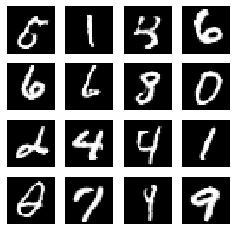

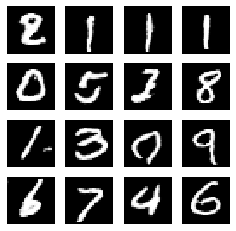

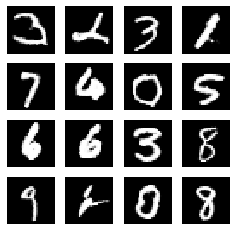

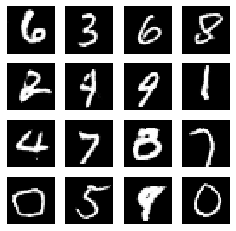

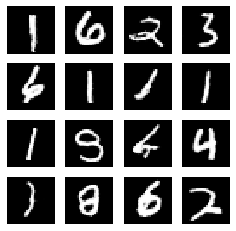

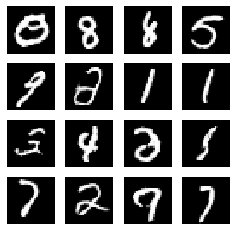

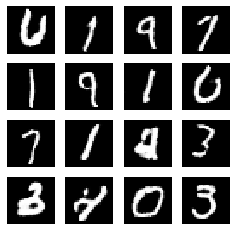

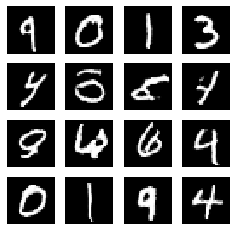

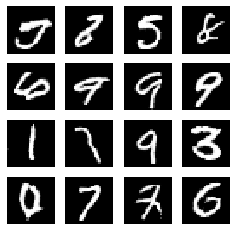

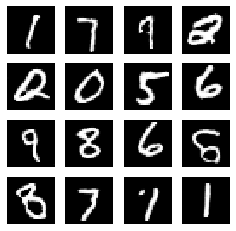

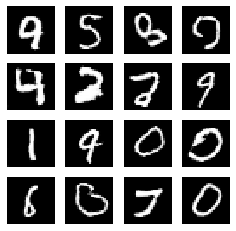

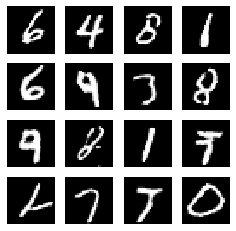

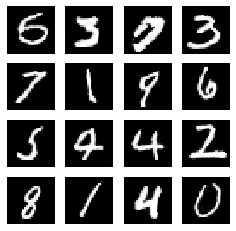

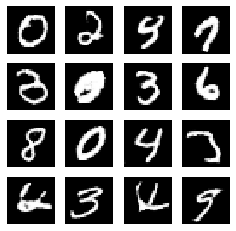

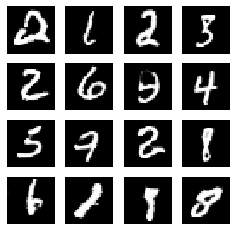

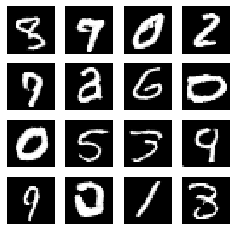

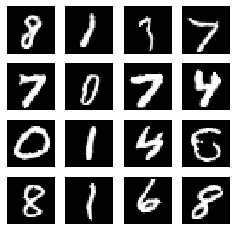

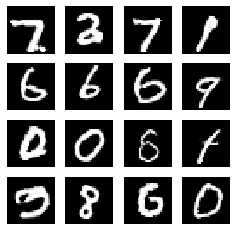

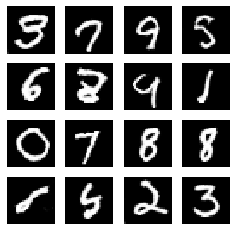

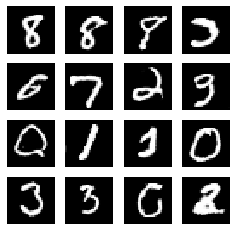

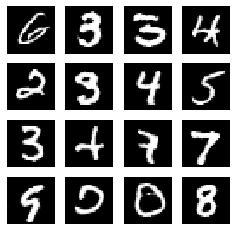

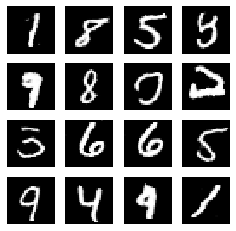

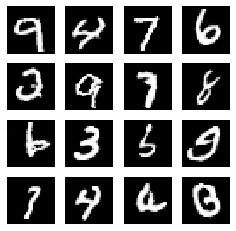

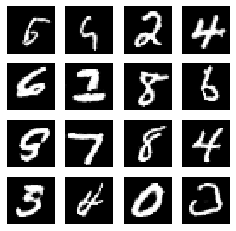

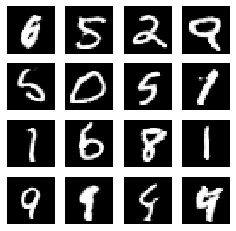

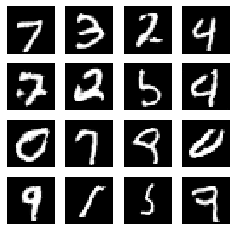

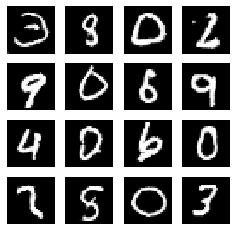

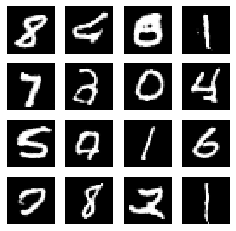

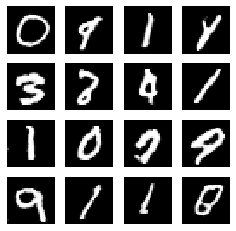

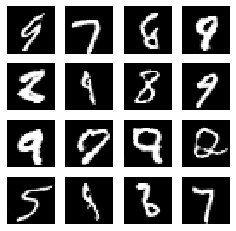

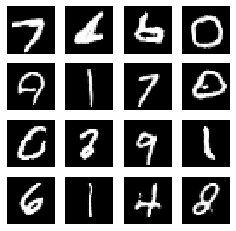

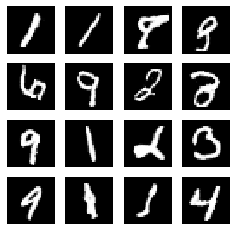

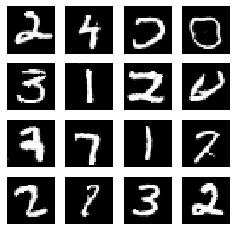

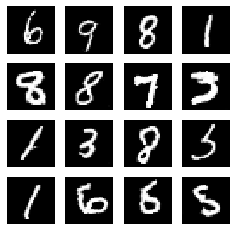

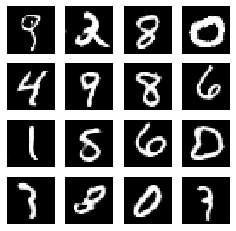

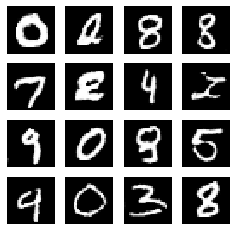

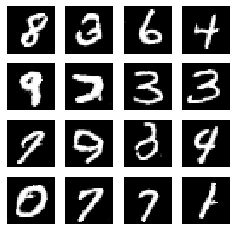

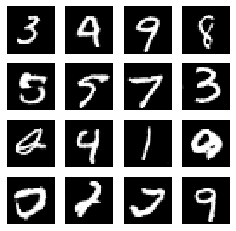

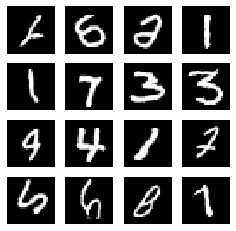

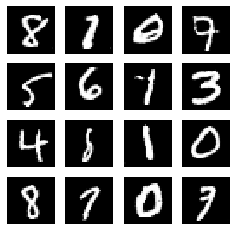

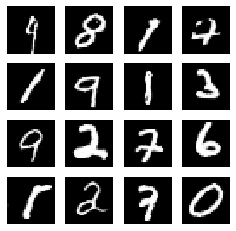

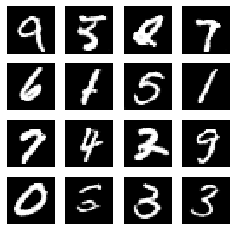

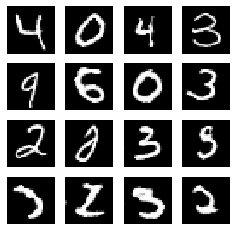

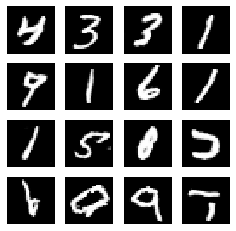

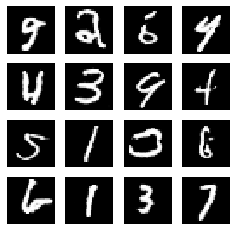

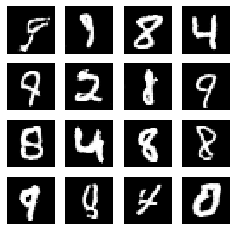

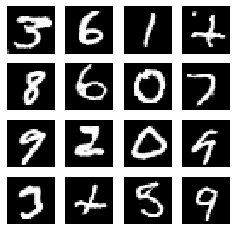

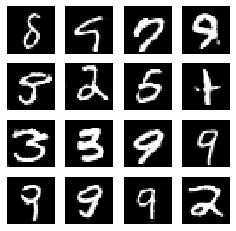

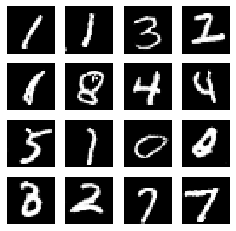

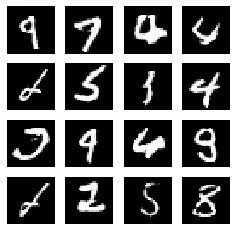

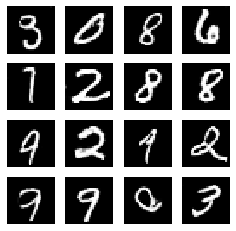

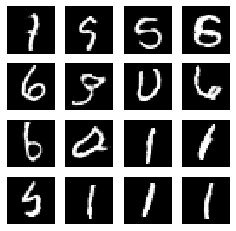

In [10]:
train(iterations, batch_size, sample_interval)

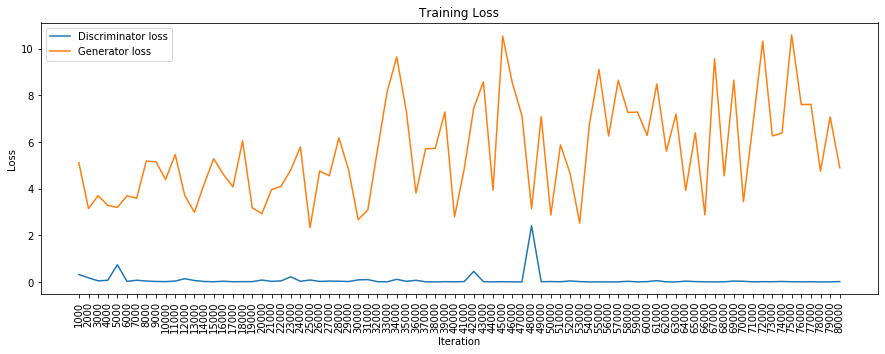

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

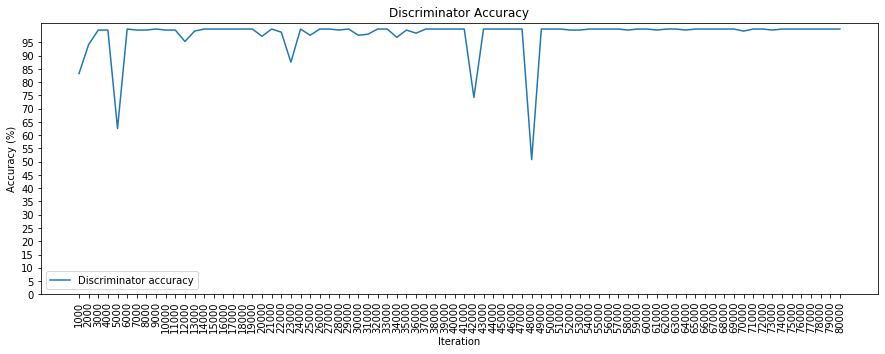

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()